## Procesamiento de Datos para conformar un conjunto de entrenamiento y validación

En este _notebook_ se procesan los archivos `.bin` y `.label` para formar nubes de puntos de dimensiones _(N, 4)_, siendo _N_ el número de puntos y _4_ las características `x`, `y`, `z` y `remissions`. Las características de todos los puntos serán normalizadas según su naturaleza y respecto a las nubes de puntos que conforman el conjunto de entrenamiento. Finalmente las nubes de puntos normalizadas se guardarán en archivos `.csv` divididas en los directorios correspondientes al entrenamiento y validación.



### Importar de dependencias

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import re
import matplotlib.pyplot as plt
import random as rand
import tkinter as tk
from tkinter import filedialog


from pathlib import Path
from sklearn.model_selection import train_test_split

count_x_train = 0
count_y_train = 0
count_x_val = 0
count_y_val = 0

### Cargar rutas de los archivos _.bin_ y _.label_

In [ ]:
# Crear una ventana oculta de Tkinter
root = tk.Tk()
root.withdraw()  # Ocultar la ventana principal

# Ruta inicial
initial_path = Path(r"C:\Users\fmartinez\Desktop\reco\datasets\gooseEx_3d_val\gooseEx_3d_val")

try:
    # Seleccionar la primera ruta
    print("Selecciona la ruta para 'point_clouds_path'")
    point_clouds_path = Path(filedialog.askdirectory(
        title="Selecciona la carpeta para 'point_clouds_path'",
        initialdir=initial_path
    ))

    # Seleccionar la segunda ruta
    print("Selecciona la ruta para 'labels_path'")
    labels_path = Path(filedialog.askdirectory(
        title="Selecciona la carpeta para 'labels_path'",
        initialdir=initial_path
    ))

    # Mostrar las rutas seleccionadas
    print(f"Ruta seleccionada para point_clouds_path: {point_clouds_path}")
    print(f"Ruta seleccionada para labels_path: {labels_path}")

except Exception as e:
    print(f"Error al seleccionar rutas: {e}")

finally:
    root.destroy()  # Asegúrate de cerrar la ventana de Tkinter

Selecciona la ruta para 'point_clouds_path'
Selecciona la ruta para 'labels_path'
Ruta seleccionada para point_clouds_path: C:\Users\fmartinez\Desktop\reco\datasets\gooseEx_3d_val\gooseEx_3d_val\lidar\val\spot_scenario08
Ruta seleccionada para labels_path: C:\Users\fmartinez\Desktop\reco\datasets\gooseEx_3d_val\gooseEx_3d_val\labels\val\spot_scenario08


### Listar y ordenar archivos _.bin_ y _.label_

In [53]:
files_list = sorted(os.listdir(point_clouds_path))
labels_list = sorted(os.listdir(labels_path))

### Leer archivos y asignación _X Y_

In [54]:
Y = []

# Reading .label files and adding to Y_DF
for file in labels_list:

    # reading a .label file
    label = np.fromfile(os.path.join(labels_path, file), dtype=np.uint32)
    label = label.reshape((-1))

    # extract the semantic and instance label IDs
    sem_label = label & 0xFFFF  # semantic label in lower half

    Y.append(pd.DataFrame(sem_label, columns=["sem_label"]))

In [55]:
X = []

# Reading .bin files and adding to X_DF
for file in files_list:
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission

    df_point_cloud = pd.DataFrame(points, columns=["x","y","z"])
    df_point_cloud["remissions"] = remissions
    X.append(df_point_cloud)

# print(X[0:2])
# print(list_labels[0:2])

del df_point_cloud # optimizar memoria

### Estudiar Clases Semánticas

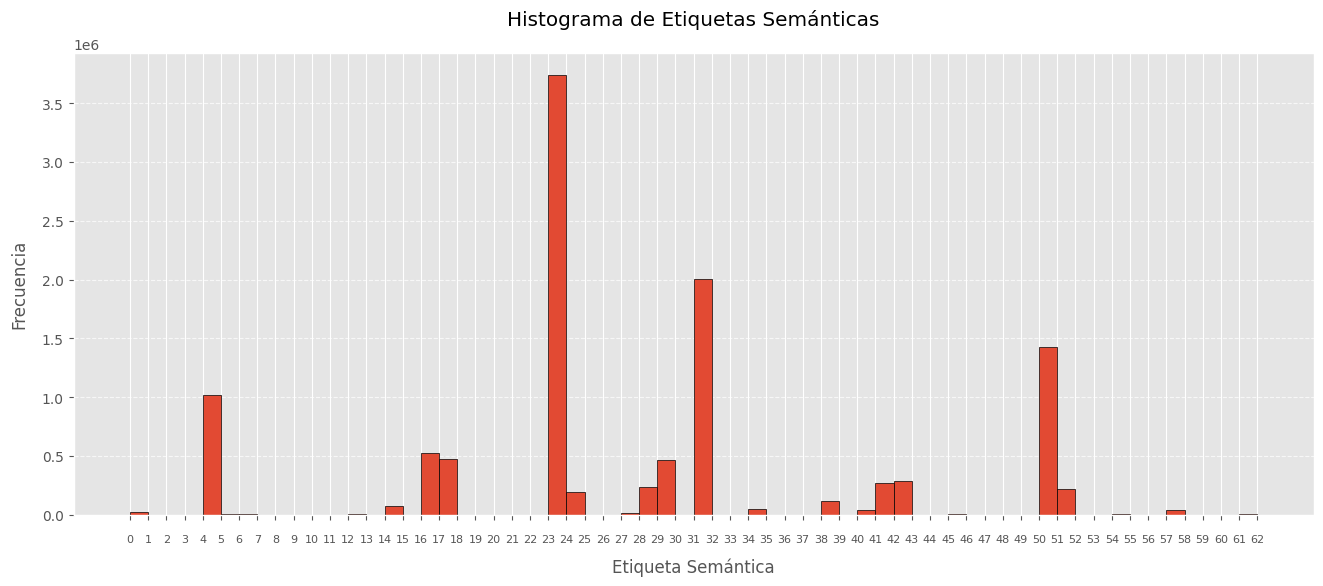

In [56]:
Y_concat = pd.concat(Y)
    
# df_list_labels


from matplotlib.ticker import FuncFormatter

# Crear el histograma
plt.figure(figsize=(16, 6))
plt.style.use('ggplot')
plt.hist(Y_concat['sem_label'], 
         bins=np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 2), 
         edgecolor='k', 
         alpha=1, 
         align='mid')

# Chatgpt code
# Configurar el formateador para el eje Y
#ax = plt.gca()
#formatter = FuncFormatter(lambda x, _: f"{int(x):,}")  # Formato con separadores de miles
#ax.yaxis.set_major_formatter(formatter)  # Aplicar el formateador

# Personalización del gráfico
plt.title("Histograma de Etiquetas Semánticas", pad=20)
plt.xlabel("Etiqueta Semántica", labelpad=10)
plt.ylabel("Frecuencia", labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar las marcas del eje X en incrementos de 1
x_ticks = np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 2, 1)
plt.xticks(x_ticks, fontsize=8)

# Ajustar padding de los x_ticks
plt.gca().tick_params(axis='x', pad=10)  # Aumenta el espacio entre los ticks y el eje

# Mostrar el gráfico
plt.show()

### Estudiar de _nº puntos_ por barrido LiDAR

In [57]:
n_points_X = []

# Reading .bin files and adding to DF
for file in os.listdir(point_clouds_path):
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remissions

    n_points_X.append(len(points))

n_points_X = np.array(n_points_X)

MIN_POINTS_X = n_points_X[n_points_X.argmin()]
nube = n_points_X.argmin()

print(f"La nube con menos puntos tiene: {MIN_POINTS_X}, es la {nube}")

La nube con menos puntos tiene: 89046, es la 11


### Calcular distancia máxima en _X_train_

In [58]:
# Normalizar las coordenadas x, y, z de cada nube por su distancia euclidiana máxima
for i, df in enumerate(X):
    # Calcular la distancia máxima euclidiana para cada nube
    d_max = np.sqrt((df[['x', 'y', 'z']] ** 2).sum(axis=1)).max()
    # Normalizar x, y, z dividiendo por la distancia máxima
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']] / d_max
    # Reasignar el dataframe normalizado a la lista X_train
    X[i] = df

# Calcular la media y desviación estándar global de 'remissions'
all_remissions = pd.concat([df['remissions'] for df in X])
mean = all_remissions.mean()
std = all_remissions.std()

print(f"mean (remissions): {mean}, std (remissions): {std}")

mean (remissions): 8.580519676208496, std (remissions): 8.661567687988281


### Dividir en subconjuntos

In [59]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=42)

len(X_train)

85

### Guardar archivos en un directorio para cada subconjunto

En el caso de querer guardar los archivos, seleccionar el intérprete de Python en la siguiente celda

In [60]:
# Linux

output_dir_x_train = "/home/felix/Escritorio/TFG/datasets_splits/goose/x_train"
output_dir_y_train = "/home/felix/Escritorio/TFG/datasets_splits/goose/y_train"
output_dir_x_val = "/home/felix/Escritorio/TFG/datasets_splits/goose/x_val"
output_dir_y_val = "/home/felix/Escritorio/TFG/datasets_splits/goose/y_val"

# MacOS

#output_dir_x_train = "/Users/felixmaral/Desktop/TFG/datasets_splits/goose/x_train"
#output_dir_y_train = "/Users/felixmaral/Desktop/TFG/datasets_splits/goose/y_train"
#output_dir_x_val = "/Users/felixmaral/Desktop/TFG/v/goose/x_val"
#output_dir_y_val = "/Users/felixmaral/Desktop/TFG/datasets_splits/goose/y_val"

# Seg

output_dir_x_train = r"C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train"
output_dir_y_train = r"C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\y_train"
output_dir_x_val = r"C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_val"
output_dir_y_val = r"C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\y_val"

os.makedirs(output_dir_x_train, exist_ok=True)
os.makedirs(output_dir_y_train, exist_ok=True)
os.makedirs(output_dir_x_val, exist_ok=True)
os.makedirs(output_dir_y_val, exist_ok=True)

# Guardar cada DataFrame en un archivo
for i, df in enumerate(X_train):
    # Define el nombre del archivo, por ejemplo: dataframe_0.csv
    file_name = f"dataframe_x_{count_x_train}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_x_train, file_name)
    
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")
    count_x_train += 1

for i, df in enumerate(Y_train):
    file_name = f"dataframe_y_{count_y_train}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_y_train, file_name)
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")
    count_y_train += 1

# Guardar cada DataFrame en un archivo
for i, df in enumerate(X_val):
    # Define el nombre del archivo, por ejemplo: dataframe_0.csv
    file_name = f"dataframe_x_{count_x_val}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_x_val, file_name)
    
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")
    count_x_val += 1

for i, df in enumerate(Y_val):
    file_name = f"dataframe_y_{count_y_val}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_y_val, file_name)
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")
    count_y_val += 1

Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_239.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_240.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_241.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_242.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_243.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_244.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_245.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_246.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_247.csv
Guardado: C:\Users\fmartinez\Desktop\reco\datasets_slipt\goose_ex_val\x_train\dataframe_x_248.csv
Guardado: C:\Users\f